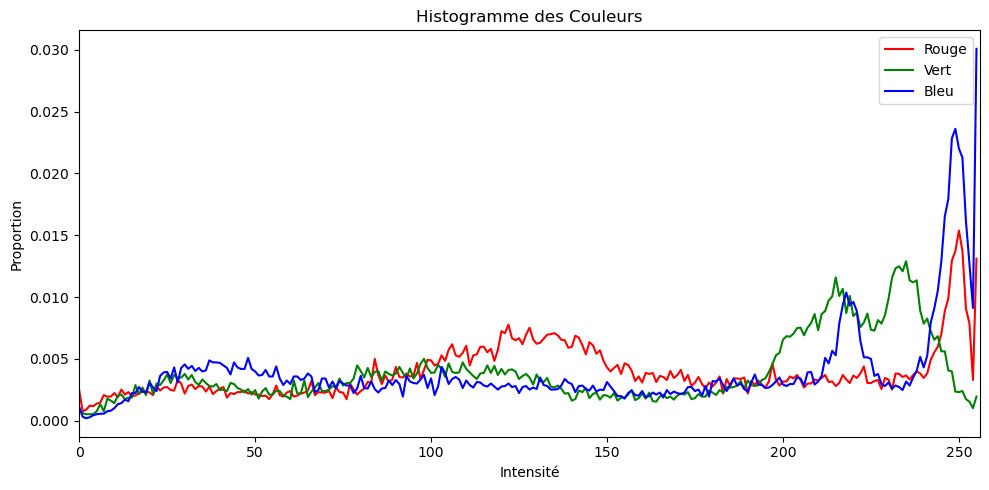

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = './img/1472.jpg'  
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])  
hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256])  
hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256])
hist_r /= hist_r.sum()
hist_g /= hist_g.sum()
hist_b /= hist_b.sum()

plt.figure(figsize=(10, 5))

plt.plot(hist_r, color='red', label='Rouge')
plt.plot(hist_g, color='green', label='Vert')
plt.plot(hist_b, color='blue', label='Bleu')

plt.title('Histogramme des Couleurs')
plt.xlabel('Intensité')
plt.ylabel('Proportion')
plt.xlim([0, 256])
plt.legend()  

plt.tight_layout()
plt.show()


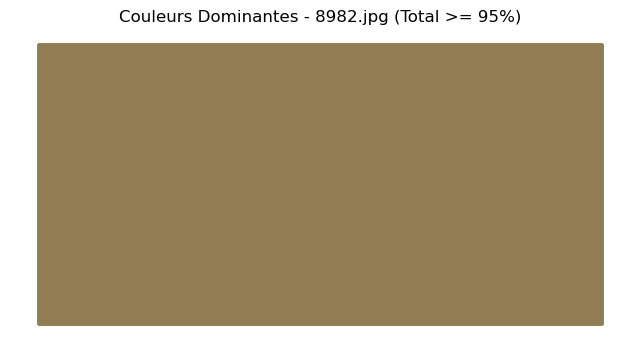

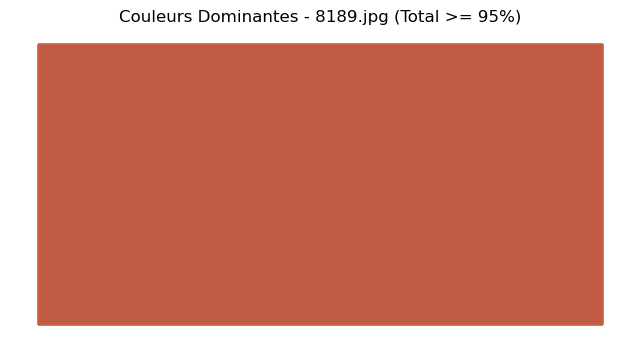

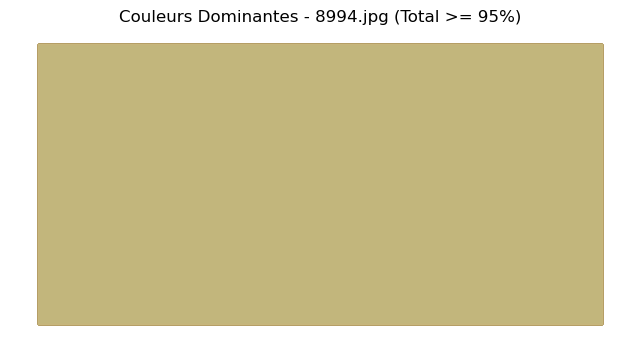

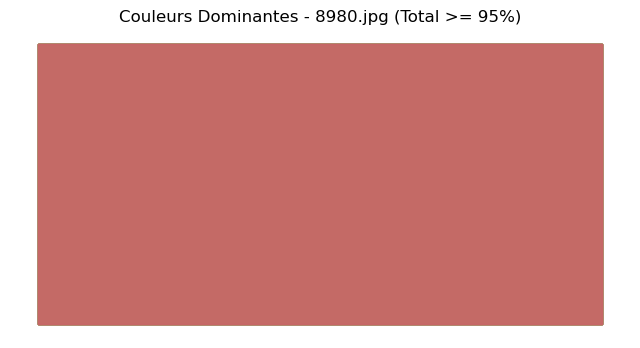

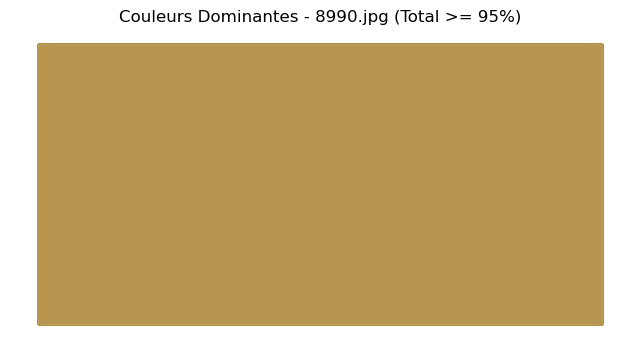

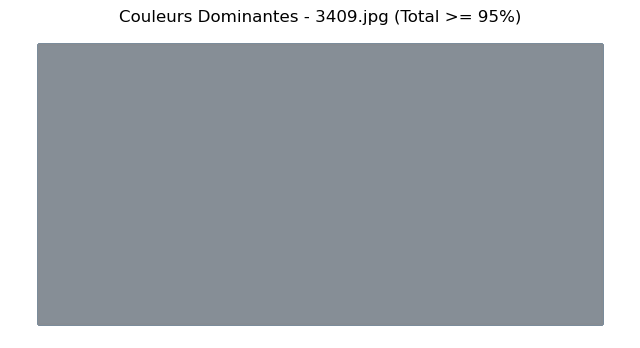

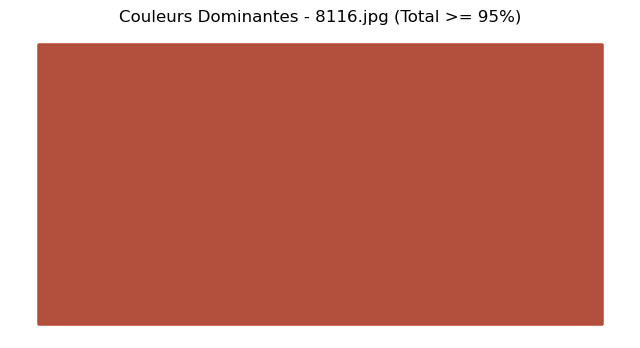

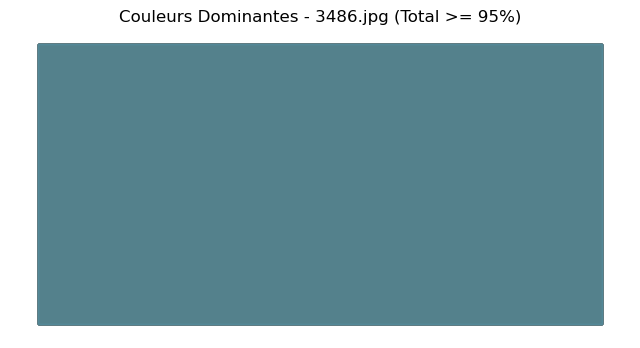

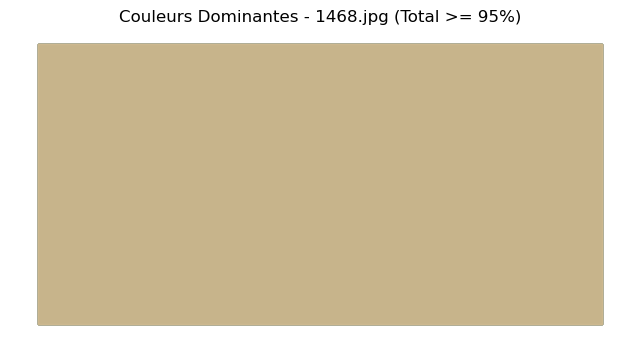

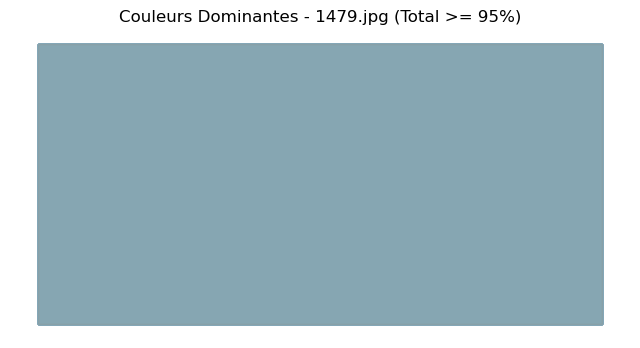

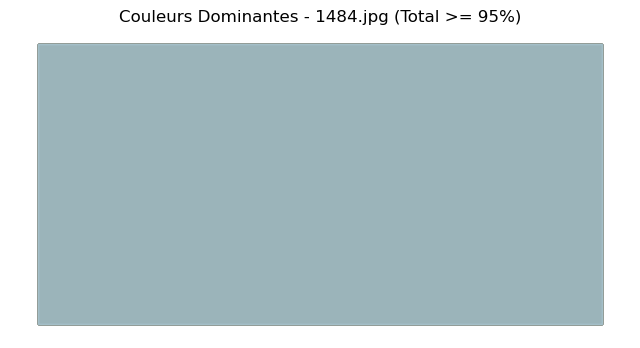

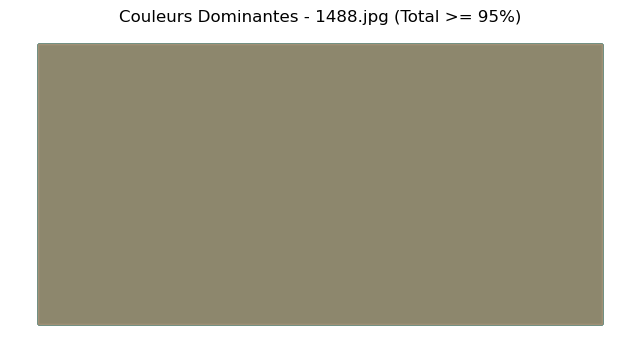

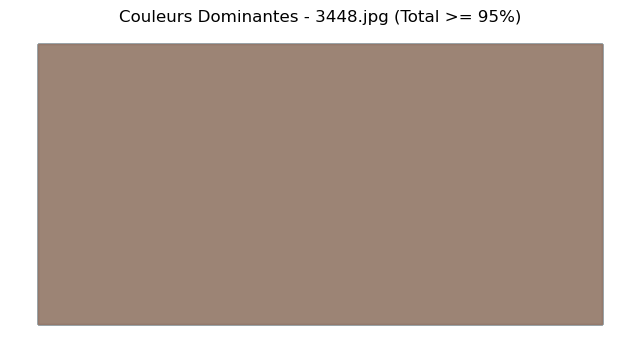

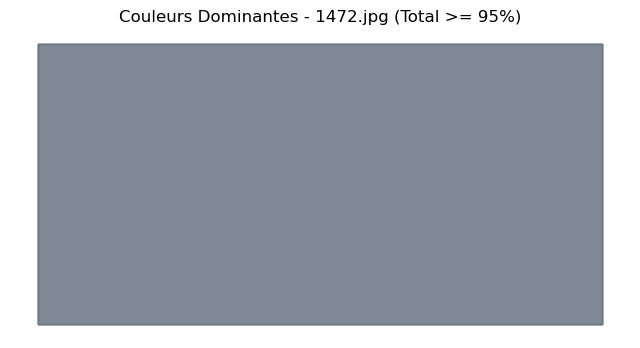

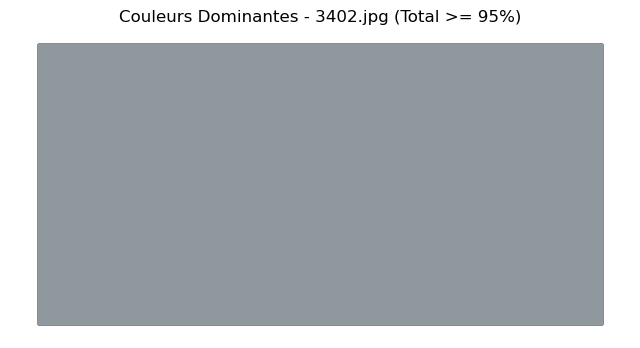

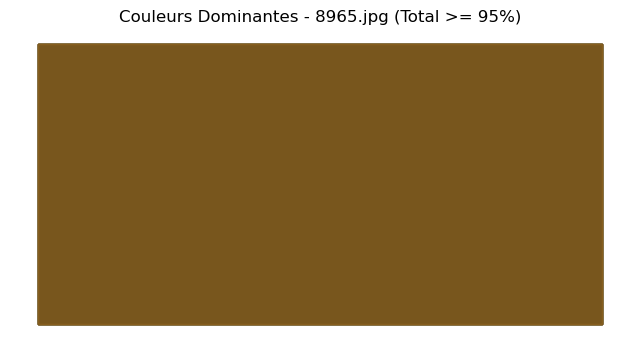

Les résultats ont été sauvegardés dans ./img/dominant_colors_results.json


In [24]:
import os
import json
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def analyze_images(folder_path, K=16):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    results = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pixel_values = image_rgb.reshape((-1, 3))
            pixel_values = np.float32(pixel_values)

            kmeans = KMeans(n_clusters=K, random_state=0)
            kmeans.fit(pixel_values)
            labels, counts = np.unique(kmeans.labels_, return_counts=True)
            total_count = sum(counts)
            proportions = counts / total_count
            
            dominant_colors_with_proportions = [
                (kmeans.cluster_centers_[i], proportions[i]) for i in range(len(proportions))
            ]
            dominant_colors_with_proportions.sort(key=lambda x: x[1], reverse=True)

            cumulative_percentage = 0
            dominant_colors = []
            for color, proportion in dominant_colors_with_proportions:
                if cumulative_percentage >= 0.95:
                    break
                cumulative_percentage += proportion
                dominant_colors.append({
                    'color': color.astype(int).tolist(),
                    'percentage': float(proportion) * 100
                })

            hist_r = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
            hist_g = cv2.calcHist([image], [1], None, [256], [0, 256]).flatten()
            hist_b = cv2.calcHist([image], [2], None, [256], [0, 256]).flatten()

            results[image_file] = {
                'dominant_colors': dominant_colors,
                'cumulative_percentage': cumulative_percentage * 100,
                'image_path': image_path,
                'histogram': {
                    'red': hist_r.tolist(),
                    'green': hist_g.tolist(),
                    'blue': hist_b.tolist()
                }
            }

            plt.figure(figsize=(8, 4))
            plt.title(f'Couleurs Dominantes - {image_file} (Total >= 95%)')
            for color in dominant_colors:
                plt.fill_between([0, 1], 0, 1, color=np.array(color["color"]) / 255, alpha=0.6)
            plt.axis('off')  
            plt.show()

    return results

def save_results_to_json(results, folder_path):
    output_file_path = os.path.join(folder_path, 'dominant_colors_results.json')
    with open(output_file_path, 'w') as json_file:
        json.dump(results, json_file, indent=4)
    print(f'Les résultats ont été sauvegardés dans {output_file_path}')

# Example usage:
folder_path = './img/'
results = analyze_images(folder_path)
save_results_to_json(results, folder_path)


In [25]:
import os
import json
import numpy as np
from sklearn.metrics import pairwise

def jaccard_distance(hist1, hist2):
    intersection = np.minimum(hist1, hist2).sum()
    union = np.maximum(hist1, hist2).sum()
    return 1 - intersection / union if union != 0 else 0

def load_dominant_colors(input_file_path):
    with open(input_file_path, 'r') as json_file:
        return json.load(json_file)

def calculate_distances(data):
    distance_results = {}
    image_keys = list(data.keys())

    for i in range(len(image_keys)):
        for j in range(i + 1, len(image_keys)):
            image1 = image_keys[i]
            image2 = image_keys[j]

            colors1 = np.array([color['color'] for color in data[image1]['dominant_colors']])
            colors2 = np.array([color['color'] for color in data[image2]['dominant_colors']])
            hist1 = np.array(data[image1]['histogram']['red'])
            hist2 = np.array(data[image2]['histogram']['red'])

            euclidean_dist_colors = np.linalg.norm(colors1.mean(axis=0) - colors2.mean(axis=0))
            mean_dist_colors = np.mean(np.abs(colors1.mean(axis=0) - colors2.mean(axis=0)))
            cosine_dist_colors = 1 - pairwise.cosine_similarity([colors1.mean(axis=0)], [colors2.mean(axis=0)])[0][0]
            jaccard_dist_hist = jaccard_distance(hist1, hist2)

            global_distance = (euclidean_dist_colors + mean_dist_colors + cosine_dist_colors + jaccard_dist_hist) / 4

            distance_results[f"{image1} vs {image2}"] = {
                'euclidean_distance_colors': euclidean_dist_colors,
                'mean_distance_colors': mean_dist_colors,
                'cosine_distance_colors': cosine_dist_colors,
                'jaccard_distance_histogram': jaccard_dist_hist,
                'global_distance': global_distance
            }
    
    return distance_results

def save_distance_results(distance_results, output_file_path):
    with open(output_file_path, 'w') as json_file:
        json.dump(distance_results, json_file, indent=4)
    print(f'Distance results for all image pairs have been saved to {output_file_path}')

# Example usage:
input_file_path = './img/dominant_colors_results.json'
output_file_path = os.path.join('./img/', 'distance_results.json')

data = load_dominant_colors(input_file_path)
distance_results = calculate_distances(data)
save_distance_results(distance_results, output_file_path)


Distance results for all image pairs have been saved to ./img/distance_results.json


In [22]:
import os
import json
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise

# Function to calculate Jaccard distance for histograms
def jaccard_distance(hist1, hist2):
    intersection = np.minimum(hist1, hist2).sum()
    union = np.maximum(hist1, hist2).sum()
    return 1 - intersection / union if union != 0 else 0

# Function to compute dominant colors and histograms
def compute_dominant_colors_and_histogram(image_path, K=16):
    image = cv2.imread(image_path)
    if image is None:
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_values = image_rgb.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # KMeans clustering to find dominant colors
    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(pixel_values)
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    total_count = sum(counts)
    proportions = counts / total_count

    # Find dominant colors with their proportions
    dominant_colors_with_proportions = [
        (kmeans.cluster_centers_[i], proportions[i]) for i in range(len(proportions))
    ]
    dominant_colors_with_proportions.sort(key=lambda x: x[1], reverse=True)

    cumulative_percentage = 0
    dominant_colors = []
    for color, proportion in dominant_colors_with_proportions:
        if cumulative_percentage >= 0.95:
            break
        cumulative_percentage += proportion
        dominant_colors.append({
            'color': color.astype(int).tolist(),
            'percentage': float(proportion) * 100
        })

    # Calculate histogram for each RGB channel separately
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256]).flatten()
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256]).flatten()

    return dominant_colors, {
        'red': hist_r,
        'green': hist_g,
        'blue': hist_b
    }

# Load existing distance results
distance_file_path = './img/distance_results.json'
with open(distance_file_path, 'r') as json_file:
    distance_results = json.load(json_file)

# Load new images from the specified folder
new_images_folder = './test/'
new_image_files = [f for f in os.listdir(new_images_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# Prepare to store comparison results
comparison_results = {}

# Compute dominant colors and histograms for new images
# Compute dominant colors and histograms for new images
for new_image_file in new_image_files:
    new_image_path = os.path.join(new_images_folder, new_image_file)
    dominant_colors, histogram = compute_dominant_colors_and_histogram(new_image_path)

    if dominant_colors is not None and histogram is not None:
        # Compare with each image in the distance results
        for existing_image_pair, distances in distance_results.items():
            existing_image1, existing_image2 = existing_image_pair.split(" vs ")
            # Check if either of the existing images is a match with the new image
            if existing_image1 == new_image_file or existing_image2 == new_image_file:
                # Calculate distances for dominant colors and histograms
                if existing_image1 == new_image_file:
                    existing_image = existing_image2
                else:
                    existing_image = existing_image1

                existing_colors = np.array([color['color'] for color in distance_results[existing_image]['dominant_colors']])
                hist_existing = np.array(distance_results[existing_image]['histogram']['red'])  # Use red histogram as an example

                # Calculate distances for dominant colors
                euclidean_dist_colors = np.linalg.norm(existing_colors.mean(axis=0) - np.array(dominant_colors).mean(axis=0))
                mean_dist_colors = np.mean(np.abs(existing_colors.mean(axis=0) - np.array(dominant_colors).mean(axis=0)))
                cosine_dist_colors = 1 - pairwise.cosine_similarity([existing_colors.mean(axis=0)], [np.array(dominant_colors).mean(axis=0)])[0][0]
                jaccard_dist_hist = jaccard_distance(histogram['red'], hist_existing)

                # Global distance considering both dominant colors and histograms
                global_distance = (euclidean_dist_colors + mean_dist_colors + cosine_dist_colors + jaccard_dist_hist) / 4
                
                # Store results for this comparison
                comparison_results[f"{new_image_file} vs {existing_image}"] = {
                    "euclidean_distance_colors": euclidean_dist_colors,
                    "mean_distance_colors": mean_dist_colors,
                    "cosine_distance_colors": cosine_dist_colors,
                    "jaccard_distance_histogram": jaccard_dist_hist,
                    "global_distance": global_distance
                }

# Sort comparisons by global distance in descending order
sorted_comparisons = sorted(comparison_results.items(), key=lambda x: x[1]['global_distance'], reverse=True)

# Print the top 6 relative images
print("Top 6 relative images (descending distance):")
for i in range(min(6, len(sorted_comparisons))):
    comparison_key = sorted_comparisons[i][0]
    distances = sorted_comparisons[i][1]
    print(f"{comparison_key} - Global Distance: {distances['global_distance']:.4f}, "
          f"Euclidean: {distances['euclidean_distance_colors']:.4f}, "
          f"Mean: {distances['mean_distance_colors']:.4f}, "
          f"Cosine: {distances['cosine_distance_colors']:.4f}, "
          f"Jaccard: {distances['jaccard_distance_histogram']:.4f}")


Top 6 relative images (descending distance):


In [21]:
# Load existing distance results
distance_file_path = './img/distance_results.json'
with open(distance_file_path, 'r') as json_file:
    distance_results = json.load(json_file)

# Debugging: Print the loaded distance results
print("Loaded distance results:", distance_results)


Loaded distance results: {'8982.jpg vs 8189.jpg': {'euclidean_distance_colors': 86.92745626705768, 'mean_distance_colors': 47.357142857142854, 'cosine_distance_colors': 0.028574500620492715, 'jaccard_distance_histogram': 0.8487312558295267, 'global_distance': 33.79047622016264}, '8982.jpg vs 8994.jpg': {'euclidean_distance_colors': 45.29426237484867, 'mean_distance_colors': 25.23809523809523, 'cosine_distance_colors': 0.007020778391675808, 'jaccard_distance_histogram': 0.36641591846639165, 'global_distance': 17.72644857745049}, '8982.jpg vs 8980.jpg': {'euclidean_distance_colors': 50.20063916262025, 'mean_distance_colors': 24.882539682539687, 'cosine_distance_colors': 0.020802053685279986, 'jaccard_distance_histogram': 0.4586903905278995, 'global_distance': 18.89066782234328}, '8982.jpg vs 8990.jpg': {'euclidean_distance_colors': 25.82436754663458, 'mean_distance_colors': 12.380952380952381, 'cosine_distance_colors': 0.0023202832835738096, 'jaccard_distance_histogram': 0.19185020336121

In [23]:
import cv2
import matplotlib.pyplot as plt

# Assuming comparison_results is already populated and sorted
sorted_comparisons = sorted(comparison_results.items(), key=lambda x: x[1]['global_distance'], reverse=True)

# Print the top 6 relative images and display them
print("Top 6 relative images (descending distance):")
for i in range(min(6, len(sorted_comparisons))):
    comparison_key = sorted_comparisons[i][0]
    distances = sorted_comparisons[i][1]
    print(f"{comparison_key} - Global Distance: {distances['global_distance']:.4f}, "
          f"Euclidean: {distances['euclidean_distance_colors']:.4f}, "
          f"Mean: {distances['mean_distance_colors']:.4f}, "
          f"Cosine: {distances['cosine_distance_colors']:.4f}, "
          f"Jaccard: {distances['jaccard_distance_histogram']:.4f}")
    
    # Load the images to display
    image1, image2 = comparison_key.split(" vs ")
    img1_path = os.path.join(existing_images_folder, image1)
    img2_path = os.path.join(existing_images_folder, image2)
    
    # Read images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    # Convert from BGR to RGB for proper color display
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Display images using matplotlib
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(image1)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(image2)
    plt.axis('off')
    
    plt.show()


Top 6 relative images (descending distance):
